<a href="https://colab.research.google.com/github/zhouy185/Exercise-Classifcations/blob/main/Exercise_Classification_with_KNN_Predicting_Patient_No_Shows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Problem

In healthcare systems, it is common that patients may not show up for their appointments, causing waste of resources and unnecessary waiting times for other patients.

* Can we predict if a patient will show up?

<img src='attachment:image.png' width='300' style='float:center'></img>

# The dataset

We will use a dataset [appointments.csv](https://raw.githubusercontent.com/zhouy185/BUS_O712/refs/heads/main/Data/appointments.csv) containing patients' apppointment records at a hospital. We will first import the dataset.

In [3]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/zhouy185/BUS_O712/refs/heads/main/Data/appointments.csv")
df.head()

,AppointmentID,Gender,AppointmentDOW,LeadTime,Age,SMS_received,NoShow
0,5756417,F,Wednesday,0,20,1,No
1,5523159,F,Tuesday,35,37,0,No
2,5693080,F,Friday,8,38,1,Yes
3,5654129,F,Friday,31,24,0,Yes
4,5641070,F,Friday,0,41,1,No


Target variable $y$: **No-show**: 'Yes' means a no-show (positive), 'No' means a show (negative)
* The problem is therefore a (binary) classification problem

Features ($X$):
* **Gender**: M or F
* **AppointmentDay** The date of the appointment
* **AppointmentDOW**: The day of week on which the appointment should take place
* **LeadTime**: The number of days between the appointment was scheduled and the appointment day
* **Age**: Age pf the patient


* **Neighborhood** The neighborhood in which the patient lives in
* **Scholarship**: A local social assistance program; 0 (no participation) or 1 (participation)
* **Hipertension**: Indicator of whether the patient has hypertension
* **Diabetes**: Indicator of whether the patient has diabete

* **Alcoholism**: Indicator of whether the patient has alcoholism
* **SMS_received**: Whether a reminder SMS was sent to the patient

One should check for missing values, duplications, outliers/anomolies, etc.



Let's examine the target variable to find how many **Yes**'s and **No**'s there are.

In [4]:
df['NoShow'].value_counts()

,count
NoShow,
No,860
Yes,245


**Question**: What may be a possible challenge for the classification problem?

The dataset is unbalanced!
* Many more **No**'s than **Yes**'s
* If we simply predict that **any** patient will show up (i.e., **No** no-show), then we will have a relatively good accuracy.

# Dealing with unbalanced dataset

What should we do?

* **Under-sampling**
    * Select and include a subset of records of the majority class, so that we have about the same number of majority-class recods and minority-class records.    

* **Over-sampling**
    * Increase the number of records of the minority class, by doing **sampling with replacements**.

Use **under-sampling** when:

* You have a large dataset, and removing some samples will not cause a significant loss of information.
* You want to speed up training and reduce memory consumption.


Use **over-sampling** when:
* Your dataset is small, and removing majority class samples would significantly reduce information.
* You want to avoid discarding any data points.
* You have enough computational resources to handle the increased dataset size.

One can also do "hybrid-sampling". How?

Now let's seperate the no-shows from the shows.

In [5]:
df_yes = df.query("NoShow == 'Yes'")
df_no = df.query("NoShow == 'No'")

display(df_yes.head())
display(df_no.head())

,AppointmentID,Gender,AppointmentDOW,LeadTime,Age,SMS_received,NoShow
2,5693080,F,Friday,8,38,1,Yes
3,5654129,F,Friday,31,24,0,Yes
9,5530556,F,Tuesday,33,49,0,Yes
10,5660217,M,Wednesday,0,9,1,Yes
15,5584749,F,Tuesday,40,63,0,Yes


,AppointmentID,Gender,AppointmentDOW,LeadTime,Age,SMS_received,NoShow
0,5756417,F,Wednesday,0,20,1,No
1,5523159,F,Tuesday,35,37,0,No
4,5641070,F,Friday,0,41,1,No
5,5690281,F,Tuesday,5,68,1,No
6,5697447,M,Friday,0,13,1,No


Then, we will use the function `df.sample()` to draw records (rows) from a DataFrame
* Use the keyword argument `n=` to specify the number of records to draw
* Use `replace=True` to allow duplications (necessary for over-sample)
* Use `random_state=` to ensure reproducibility

In [6]:
n_yes = len(df_yes)
n_no = len(df_no)
print(f"n_yes={n_yes}, n_no={n_no}")

df_yes_os = df_yes.sample(n=n_no,replace=True,random_state=42)

df_yes_os

n_yes=245, n_no=860


,AppointmentID,Gender,AppointmentDOW,LeadTime,Age,SMS_received,NoShow
433,5686132,F,Monday,26,17,0,Yes
808,5697976,M,Thursday,3,66,1,Yes
393,5565628,F,Monday,21,23,0,Yes
58,5675275,F,Friday,11,29,1,Yes
440,5643321,M,Monday,7,38,1,Yes
...,...,...,...,...,...,...,...
535,5747145,F,Wednesday,2,21,1,Yes
890,5647014,F,Friday,18,58,1,Yes
784,5521644,F,Friday,31,30,0,Yes
604,5595508,M,Monday,28,5,1,Yes


We can verify that `df_yes_os` has duplicated records.

In [7]:
df_yes_os['AppointmentID'].value_counts().head()

,count
AppointmentID,
5743050,11
5608023,11
5748577,8
5631432,8
5638271,8


Now combine the two parts back together.
* We will use `pd.concat()` to concatenate the two DataFrames containing no-shows and shows.
* by default, it vertically concatenates the DataFrames; Use `axis=1` if need to do horizontal concat


<img src="attachment:image.png" width="1000"></img>

In [8]:
df_os = pd.concat([df_yes_os,df_no])
df['NoShow'].value_counts()

,count
NoShow,
No,860
Yes,245


Let us seperate X (features) and y (target).

Moreover, in X, we will **not** include Patient and Appointment IDs, Appointment Date, or Handcap. (Note that most records have `Handcap=0`.)

In [9]:
# Construct the target variable from the original dataset

y = df_os['NoShow'].map({'Yes':1,'No':0})
X = df_os.drop(columns=['NoShow','AppointmentID'])

display(X)

,Gender,AppointmentDOW,LeadTime,Age,SMS_received
433,F,Monday,26,17,0
808,M,Thursday,3,66,1
393,F,Monday,21,23,0
58,F,Friday,11,29,1
440,M,Monday,7,38,1
...,...,...,...,...,...
1099,M,Friday,2,59,1
1100,F,Wednesday,0,1,1
1101,F,Wednesday,0,23,1
1102,M,Thursday,20,6,0


## Train-test split

We will split the scaled feature data and the target variable.
* Note that the `stratify=y` argument will retain the ratio of positive class to the negative class in the training dataset and testing dataset the same as the original data before splitting.

In [10]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,
                                                 random_state=42)

y_train.value_counts()

,count
NoShow,
0,695
1,681


## Use the `pipeline` model in `sklearn` to combine preprocessing and fitting.

First, construct a column transformer for preprocessing



In [11]:
# Define the categorical and numerical features

cat_cols = ['Gender', 'AppointmentDOW']
num_cols = ['LeadTime', 'Age','SMS_received']


In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Note: ct will be applied on X_train

ct = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(sparse_output=False, drop="first"), cat_cols),
        ("num", StandardScaler(), num_cols),
    ],
    remainder="drop"  # what to do with the rest ("drop" or "passthrough")
)

## 📌 Implement the KNN model

Now we will create and fit a KNN model.
* We need to import the function `KNeighborsClassifier()` from the module `neighbors` in `sklearn`.

In [13]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=5)

Next, define a `pipeline` as a combined model of preprocess and classification.

In [14]:
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=[
    ("preprocess", ct),
    ("model", model)
])

pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['Gender', 'AppointmentDOW']),
                                                 ('num', StandardScaler(),
                                                  ['LeadTime', 'Age',
                                                   'SMS_received'])])),
                ('model', KNeighborsClassifier())])

Finally, fit the pipe line.


In [15]:
pipe.fit(X_train, y_train)

pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['Gender', 'AppointmentDOW']),
                                                 ('num', StandardScaler(),
                                                  ['LeadTime', 'Age',
                                                   'SMS_received'])])),
                ('model', KNeighborsClassifier())])

## Prediction on new data

Recall that logistic regression predicts the **probability** of being in **class 1**.

We can use `model.predict_proba()` to make a probabilistic prediction
* The input argument can be a 2D-array or a DataFrame of new data records


In [16]:
list(X_train.columns)
new_data = ['M','Tuesday',30,50,0]
df_new_data = pd.DataFrame([new_data],columns=list(X_train.columns))
df_new_data


,Gender,AppointmentDOW,LeadTime,Age,SMS_received
0,M,Tuesday,30,50,0


In [17]:
pipe.predict(df_new_data)

array([0])

Let's predict on the testing data.

In [18]:
y_prob = pipe.predict_proba(X_test)
y_prob

array([[0.8, 0.2],
       [0.2, 0.8],
       [0. , 1. ],
       [0.4, 0.6],
       [0. , 1. ],
       [0.4, 0.6],
       [0. , 1. ],
       [0. , 1. ],
       [1. , 0. ],
       [0.8, 0.2],
       [1. , 0. ],
       [0.4, 0.6],
       [0.6, 0.4],
       [0. , 1. ],
       [0. , 1. ],
       [0.2, 0.8],
       [0.2, 0.8],
       [0. , 1. ],
       [0. , 1. ],
       [0. , 1. ],
       [0.2, 0.8],
       [1. , 0. ],
       [0.2, 0.8],
       [1. , 0. ],
       [0.8, 0.2],
       [0.6, 0.4],
       [1. , 0. ],
       [0.4, 0.6],
       [0. , 1. ],
       [0.6, 0.4],
       [0.4, 0.6],
       [0.2, 0.8],
       [0.8, 0.2],
       [0.2, 0.8],
       [0. , 1. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [0. , 1. ],
       [0.4, 0.6],
       [0.2, 0.8],
       [0.6, 0.4],
       [0.2, 0.8],
       [0.8, 0.2],
       [1. , 0. ],
       [1. , 0. ],
       [0.6, 0.4],
       [1. , 0. ],
       [0.8, 0.2],
       [0.2, 0.8],
       [0.4, 0.6],
       [0. , 1. ],
       [0.8,

Each row has two probility values.
* They are the probabilities of being a class 0 (show) and a class 1 (no-show) patient, for the corresponding row in the testing dataset.


### How do we make binary classifications?

**Threshold-based** classification
* If the probability of being in class 1 (no-show) is above a certain **threshold**, then predict no-show
* Otherwise, predict show.

The function `model.predict()` provides the classification, with the default threshold **0.5**.

In [19]:
y_pred=pipe.predict(X_test)
y_pred

array([0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,

## Evaluation of the model

How to evaluate the fitted model's performance?

Performance metrics:
* The confusion matrix
* Metrics in the classification report
* The ROC curve

### The confusion matrix and the classification report

Let's import the methods `confusion_matrix` and `classification_report` to get the performance measures.

In [20]:
from sklearn.metrics import confusion_matrix, classification_report

Get the confusion matrix.

In [21]:
cm = confusion_matrix(y_test,y_pred)
print(cm)

[[110  55]
 [ 28 151]]


Get the classification report.

In [22]:
cr = classification_report(y_test,y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.80      0.67      0.73       165
           1       0.73      0.84      0.78       179

    accuracy                           0.76       344
   macro avg       0.77      0.76      0.76       344
weighted avg       0.76      0.76      0.76       344



One may also get the scores individually.

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy={accuracy:0.4f}, Precision={precision:0.4f}, Recall={recall:0.4f}, F1={f1:0.4f}")

Accuracy=0.7587, Precision=0.7330, Recall=0.8436, F1=0.7844


Refer to the lecture slides for interpretations of the performance measures.

### The ROC curve and the AUC score

The **receiver operating curve** plots:
* the True Positive Rate (Recall) on the y-axis, vs.
* the False Positive Rate on the x-axis,

for *various probability thresholds*.

The following function generates the ROC curve based on a model.

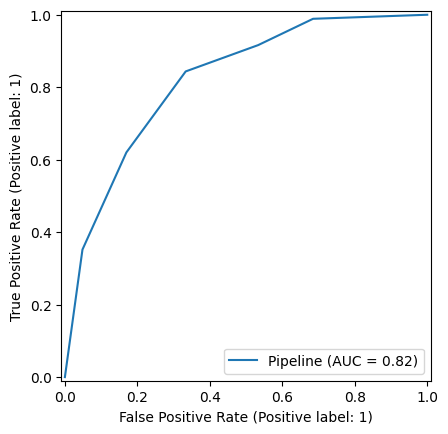

In [24]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(pipe, X_test, y_test)

To plot the ROC curve, we will use the function `roc_curve` in the `sklearn.metrics` module to get false positive rates (`fpr`) and false positive rates (`tpr`) for different values of thresholds.
* The input arguments to the `roc_curve` are:
    * `y_test`, and
    * the **probability of being in class 1** (no-show)

The **area under the curve** measures overall ability of the model to distinguish between classes
* The larger, the better performance of the model
* Being greater than 0.5 means that it is better than random guesses

We can use the `roc_auc_score` function in the `sklearn.metrics` module to get the AUC score.
* The input arguments are:
    * the observations in the test set (`y_test`)
    * the predicted probability of the positive class in the test set `y_prob[:,1]`

In [25]:
from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score(y_test,y_prob[:,1])

auc_score

np.float64(0.8208904689351617)

The definition of a "good" AUC score depends heavily on the specific domain or use case.

Rules of thumb:
* a score 0.5 is the same as a random guess
* a score of 0.7 or higher is often considered acceptable/adequate